# Lession 1:

> FastAI course lesson one

In [ ]:
#| default_exp core

## Check for all installs and versions

In [ ]:
!conda list | findstr "pytorch"

pytorch                   2.0.1           py3.11_cuda11.8_cudnn8_0    pytorch
pytorch-cuda              11.8                 h24eeafa_5    pytorch
pytorch-ignite            0.4.12                   pypi_0    pypi
pytorch-lightning         2.0.5                    pypi_0    pypi
pytorch-mutex             1.0                        cuda    pytorch


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
!pip list | findstr "fastai" 

fastai                   2.7.12


In [ ]:
!pip list | findstr "duckduckgo"

duckduckgo-search        3.8.3


In [ ]:
!pip list | findstr "fastbook"

fastbook                 0.0.29


In [ ]:
import torch

In [ ]:
torch.cuda.is_available()

True

## Generate Data Images

In [ ]:
from fastbook import search_images_ddg
from fastdownload import download_url
from fastai.vision.all import *
import os

In [ ]:
#|exports
#|code-fold: true
def download_pic(name):   
    # File path of the image
    image_path = f'{name}.jpg'

    # Check if the image file exists
    if os.path.exists(image_path):
        print("Image file exists.")
    else:
        print("Image file does not exist.")
        download_url(
            search_images_ddg(f'{name}',
            max_images=1)[0], f'{name}.jpg',
            show_progress=False
        )
    return Image.open(f'{name}.jpg').to_thumb(256,256)

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

Image file does not exist.


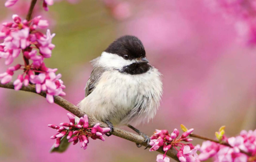

In [ ]:
download_pic('bird')

...and then download a URL and take a look at it:

Now let's do the same with "forest photos":

Image file does not exist.


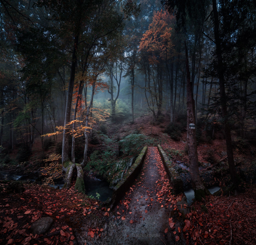

In [ ]:
download_pic('forest')

In [ ]:
#|exports
#|code-fold: true
def create_searches_folder(folder_path, searches):
    for i in searches:
        dest = (folder_path/i)
        dest.mkdir(exist_ok=True, parents=True)
        print(f'created {i} folder')

In [ ]:
#|exports
#|code-fold: true
def download_search_images(folder_path, searches, amount):
    for j in searches:
        print(f"downloading images for: {j}")
        download_images(
            folder_path/j,
            urls=search_images_ddg(f'{j} photo', amount),
            n_workers=16
        )

In [ ]:
#|exports
#|code-fold: true
def verify_pics(folder_path):
    failed = verify_images(get_image_files(folder_path))
    failed.map(Path.unlink)
    print(f"Number of images failed: {len(failed)}")

In [ ]:
#|exports
#|code-fold: true
def resize_pics(folder_path, searches):
    for k in searches:
        resize_images(
            folder_path/k,
            max_size=400,
            dest=folder_path/k,
            max_workers=8
        )
        print(f"resizing images for: {k}")

In [ ]:
#|exports
#|code-fold: true
def create_data_folder(folder_path, searches, amount):
    if os.path.exists(folder_path):
        print(f"Folder already exists: {folder_path}")
    else:   
        create_searches_folder(folder_path, searches)
        download_search_images(folder_path, searches, amount)
        verify_pics(folder_path)
        resize_pics(folder_path, searches)

        

In [ ]:
#|code-fold: true
searches = 'forest','bird'
path = Path('bird_or_not')

create_data_folder(path, searches, 200)

Folder already exists: bird_or_not


## Training the model

```sh
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)
```

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 
    
To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).